<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/MR_ergontropic_torsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

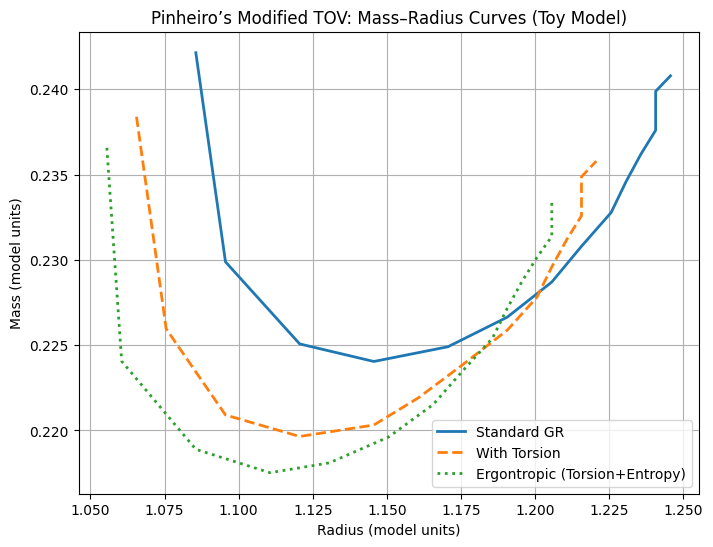

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ─────────── Toy Model Parameters ─────────────────────────────────────────────
# We use dimensionless “toy” units: G = c = 1, radius in arbitrary units, mass in same units.

# Polytropic EOS: p = K * ρ^Gamma
K = 5.0        # polytropic constant (dimensionless; tuned so radius < 10 units)
Gamma = 2.0    # polytropic index

# Pinheiro ergontropic couplings (dimensionless)
lambda0 = 0.02   # torsion‐coupling strength
sigma0  = 0.01   # entropy‐coupling strength
Omega_NS = 1.0   # dimensionless spin frequency

# ─────────── Equation of State (EOS) ───────────────────────────────────────────
def eos_p(rho):
    """Pressure: p = K * rho^Gamma."""
    return K * rho**Gamma

def eos_eps(rho):
    """Energy density: epsilon = rho + p/(Gamma-1)."""
    p = eos_p(rho)
    return rho + p / (Gamma - 1)

# ─────────── Effective Energy Densities ────────────────────────────────────────
def eps_standard(rho):
    """Standard GR: epsilon = rho + p/(Gamma − 1)."""
    return eos_eps(rho)

def eps_torsion(rho):
    """With torsion: epsilon → epsilon + lambda0 * rho * Omega_NS."""
    return eos_eps(rho) + lambda0 * rho * Omega_NS

def eps_ergon(rho):
    """With torsion + entropy: epsilon → epsilon + lambda0 * rho * Omega_NS + sigma0 * rho."""
    return eos_eps(rho) + lambda0 * rho * Omega_NS + sigma0 * rho

# ─────────── Modified TOV Equations ─────────────────────────────────────────────
def tov_rhs(r, y, eps_func):
    """
    Returns [dm/dr, dp/dr] for modified TOV:
      m'(r) = 4π r^2 ε_eff(ρ)
      p'(r) = −(ε_eff + p)(m + 4π r^3 p)/(r(r − 2m))
    y = [m(r), p(r)], ε_eff = eps_func(ρ), ρ = (p/K)^(1/Gamma).
    """
    m, p = y
    if p <= 0 or r <= 0:
        return [0.0, 0.0]
    rho = (p / K)**(1.0 / Gamma)
    eps = eps_func(rho)
    denom = r * (r - 2 * m)
    if denom <= 0:
        # Avoid singularity if r ≤ 2m
        return [0.0, 0.0]
    dpdr = - (eps + p) * (m + 4 * np.pi * r**3 * p) / denom
    dmdr = 4 * np.pi * r**2 * eps
    return [dmdr, dpdr]

def integrate_tov(rho_central, eps_func):
    """
    Integrate modified TOV from r ≈ 0 to r_max, stopping when p ≈ 0.
    rho_central: central density (dimensionless).
    eps_func: one of (eps_standard, eps_torsion, eps_ergon).
    Returns (R_surface, M_surface) or (None, None) if no surface.
    """
    p_central = eos_p(rho_central)
    y0 = [1e-8, p_central]                 # small initial mass, central pressure
    r_eval = np.linspace(1e-6, 10.0, 2000)  # integrate out to r_max = 10 units

    sol = solve_ivp(
        fun=lambda rr, yy: tov_rhs(rr, yy, eps_func),
        t_span=(1e-6, 10.0),
        y0=y0,
        t_eval=r_eval,
        method='RK45',
        atol=1e-8,
        rtol=1e-8
    )

    if (not sol.success) or (sol.y.shape[0] < 2):
        return None, None

    m_vals, p_vals = sol.y[0], sol.y[1]
    idx_surface = np.where(p_vals <= 0)[0]
    if len(idx_surface) == 0:
        return None, None

    i = idx_surface[0]
    R = r_eval[i]      # radius at surface
    M = m_vals[i]      # enclosed mass at surface
    return R, M

# ─────────── Compute Mass–Radius Curves ────────────────────────────────────────
central_rhos = np.linspace(0.5, 3.0, 15)  # central densities in [0.5, 3.0]

MR_standard = []
MR_torsion  = []
MR_ergon    = []

for rho_c in central_rhos:
    Rs, Ms = integrate_tov(rho_c, eps_standard)
    if Rs is not None:
        MR_standard.append((Rs, Ms))

    Rt, Mt = integrate_tov(rho_c, eps_torsion)
    if Rt is not None:
        MR_torsion.append((Rt, Mt))

    Re, Me = integrate_tov(rho_c, eps_ergon)
    if Re is not None:
        MR_ergon.append((Re, Me))

MR_standard = np.array(MR_standard)
MR_torsion  = np.array(MR_torsion)
MR_ergon    = np.array(MR_ergon)

# ─────────── Plotting ──────────────────────────────────────────────────────────
plt.figure(figsize=(8, 6))

if MR_standard.size > 0:
    plt.plot(MR_standard[:, 0], MR_standard[:, 1],
             label='Standard GR', linewidth=2)
if MR_torsion.size > 0:
    plt.plot(MR_torsion[:, 0], MR_torsion[:, 1],
             '--', label='With Torsion', linewidth=2)
if MR_ergon.size > 0:
    plt.plot(MR_ergon[:, 0], MR_ergon[:, 1],
             ':', label='Ergontropic (Torsion+Entropy)', linewidth=2)

plt.xlabel('Radius (model units)')
plt.ylabel('Mass (model units)')
plt.title('Pinheiro’s Modified TOV: Mass–Radius Curves (Toy Model)')
plt.legend()
plt.grid(True)
plt.show()
